## **Introduction**
#### This is a notebook that will help you understand the data better, It will help to facilitate the case "Predicting Energy Behavior of Prosumers" and make the features more clear, as well as give each feature a more specific yet easy-to-understand description, by using a well-structured notebook and good explanations.


<div style="border-radius:10px; border: #002400 solid; padding: 10px; background-color: #c8f7c8; font-size:100%;">
🎯 Your target in this competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. You'll have access to weather data, the relevant energy prices, and records of the installed photovoltaic capacity.

## **Project Type**
#### 📈 Time Series Forecasting. 

## **Highlighted Definitions**
#### <u>**Prosumers**</u> Means in our case the person that consume energy and produce it 

<img src ="http://www.ecatoday.co.uk/getmedia/391e306e-56b7-4ecf-87c3-0f84a076d618/prosumer-fig-2.jpg" width=750>

#### <u>**Energy Imbalance**</u> The difference between the quantity of electricity notified to the transmission, Or distribution system operator “Prosumer’s in our case” for injection or withdrawal, At one or more given locations over a given time period and the metered quantity of electricity withdrawn or injected at one or more given locations over the same time period


#### <u>**Installed Photovoltaic Capacity**</u> The actual generating capacity of the generating facility in Kilowatts

## **Features Description**

#### • ***train.csv***
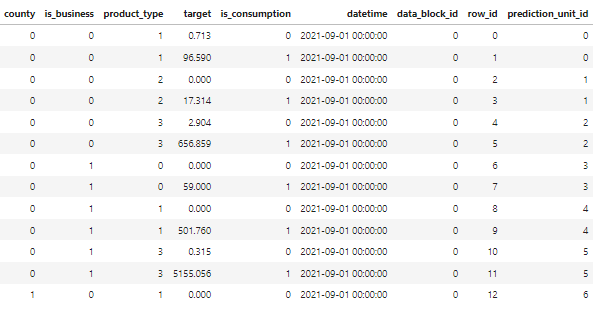

#### If we look closely to the dataset, we will find that it’s arranged from ***county***, ***is_business***, ***product_type*** and ***is_consumption*** respectively.
#### The train dataset is a result of monitoring the energy consumption and production (***target***) for initially 61 prosumer’s units from 16 different counties (***county***), between business prosumers and individuals (***is_business***), and for 4 unique types of solar panels products (***product_type***).
#### Each prosumer’s unit (***prediction_unit_id***) has two observations every hour (***datetime***), One observation for energy consumption and one for the energy production (***is_consumption***).


#### • ***client.csv***
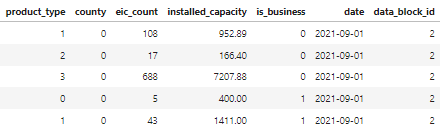
#### The units in the data are distinguished by product type, whether the unit belongs to a business or an individual, and the county. client.csv contains the total number of consumption points (***eic_count***) and the installed capacity (***installed_capacity***) for each unit every day.

#### ***forecast_weather.csv***
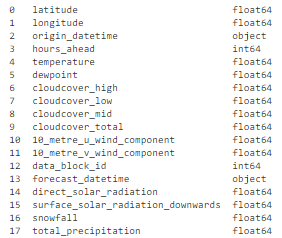
#### It’s obvious that the (***latitude***) and (***longitude***) combined represent a location on the earth's map. Every two days, the weather is forecast for two days ahead. The (***origin_datetime***) column represents the time the forecast is being made, and the (***hours_ahead***) column reflects how many hours have passed since the last time a forecast was made. (***forecast_datetime***) is the actual live time where the forecast should be relevant.
#### How does the weather affect the performance of solar panels? Everything from temperature to cloud cover influences how much electricity your system produces.

#### Research confirmed that it’s not necessary for the weather to be shiny and sunny so the solar panels could perform well, But actually, the solar panels, like any other electric device, work more efficiently in cold temperatures.

#### You can imagine the solar panels as a router that produces a Wi-Fi signal. Anything that stands between the solar panels and the sun reduces the amount of energy the unit produces. Clouds and fog are good examples of things that could stand between the panel and the sun.


#### ***historical_weather.csv***
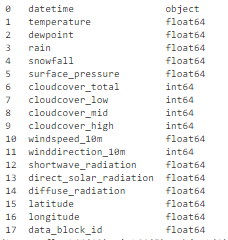
#### Differs from forecast_weather in that it's the true weather in each hour and coordination represented in the data,
#### histroical_weather also contains (***rain***) feature which is not represented in the forecast_weather data


<div style="border-radius:10px; border: #002400 solid; padding: 10px; background-color: #c8f7c8; font-size:100%;">
    
#### 🤔 How Solar Energy, Gas and Electricity are related? 
Answer will be in the EDA Notebook that will contain many useful insights that i'm sure will help you improve your competition score, So if you find this notebook helpful please upvote and follow and let's go to the code.   

## **Imports**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
# import enefit
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')


In [16]:
client_df = pd.read_csv('client.csv')
electricity_df = pd.read_csv('electricity_prices.csv')
gas_df = pd.read_csv('gas_prices.csv')
hw_df = pd.read_csv('historical_weather.csv')
fw_df = pd.read_csv('forecast_weather.csv')
train = pd.read_csv('train.csv')
locations = pd.read_csv('county_lon_lats.csv')


## **Train function**

In [17]:
def preTrain(data, client, hist_weather,
               forecast_weather, electricity, gas, locations):
    
    #Dropping (target) nan values
    data= data[data['target'].notnull()] 
    
    #Converting (datetime) column to datetime
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    
    #Renaming (forecast_date) to (datetime) for merging with the train data later
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    
    #Converting (datetime) column to datetime
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)
    
    #Decreasing (data_block_id) in client data because it's 2 steps ahead from train's data (data_block_id)
    client['data_block_id'] -= 2
    
      
    """locations is a custom data that will help replace (latitude) and (longitude)
    columns by the counties for each coordination | you can find the data in Input """
    locations = locations.drop('Unnamed: 0', axis= 1) 
        
    #Rounding the (latitude) and (longitude) for 1 decimal fraction
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude',
                                                                    'longitude']].astype(float).round(1)
        
    #Merging counties in locations data with the coordinations in the forecast_weather data
    forecast_weather= forecast_weather.merge(locations, how='left',
                                             on=['longitude','latitude'])
        
    #dropping nan values
    forecast_weather.dropna(axis= 0, inplace= True)    
    
    #Converting (county) column to integer
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    
    #Dropping the columns we won't need | We will use the (forecast_datetime) column instead of the (origin_datetime)
    forecast_weather.drop(['origin_datetime', 'latitude',
                           'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    
    #Renaming (forecast_datetime) to (datetime) for merging with the train data later
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    
    #Converting (datetime) column to datetime
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    
    """Grouping all forecast_weather columns mean values by hour, So each hour
    will have the mean values of the forecast_weather columns""" 
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].
                                            dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                                            'datetime'], axis= 1)
                                                                     .columns)].mean().reset_index()
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime['datetime']= pd.to_datetime(
        forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    """Grouping all forecast_weather columns mean values by hour and county, So each hour and county
    will have the mean values of the forecast_weather columns for each county""" 
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].
                              dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                              'datetime'], axis= 1)
                                                       .columns)].mean().reset_index()
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime_county['datetime']= pd.to_datetime(
        forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

    #Rounding the (latitude) and (longitude) for 1 decimal fraction           
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)

    #Merging counties in locations data with the coordinations in the historical_weather data
    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    
    #Dropping nan values
    hist_weather.dropna(axis= 0, inplace= True)
    
    #Dropping the columns we won't need
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)
    
    #Converting (county) to integer
    hist_weather['county'] = hist_weather['county'].astype('int64')
    
    #Converting (datetime) column to datetime
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)
    
    """Grouping all historical_weather columns mean values by hour, So each hour
    will have the mean values of the historical_weather columns"""     
    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].
                                            dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                                            'datetime',
                                                                                        'data_block_id'], axis= 1)
                                                                     .columns)].mean().reset_index()    
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime['datetime']= pd.to_datetime(
        hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    #Merging (data_block_id) back after dropping it in the last step | (data_block_id will be used to merge with train data)
    hist_weather_datetime= hist_weather_datetime.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    """Grouping all historical_weather columns mean values by hour and county, So each hour
    will have the mean values of the historical_weather columns for each county"""   
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].
                              dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                              'datetime', 'data_block_id'], axis= 1)
                                                       .columns)].mean().reset_index() 
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime_county['datetime']= pd.to_datetime(
        hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    
    #Merging (data_block_id) back after dropping it in the last step
    hist_weather_datetime_county= hist_weather_datetime_county.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    #Adding year column in train data
    data['year'] = data['datetime'].dt.year
    
    #Adding month column in train data
    data['month'] = data['datetime'].dt.month
    
    #Adding day column in train data
    data['day'] = data['datetime'].dt.day
    
    #Adding hour column in train data
    data['hour'] = data['datetime'].dt.hour
    
    #Adding dayofweek column in train data
    data['dayofweek'] = data['datetime'].dt.dayofweek
    
    #Adding dayofyear column in train data
    data['dayofyear']= data['datetime'].dt.dayofyear
    
    #Adding hour column to electricity used to merge with the train data
    electricity['hour'] = electricity['datetime'].dt.hour

    #Merging train data with client data
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])
    
    #Merging train data with gas data
    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    #Merging train data with electricity data    
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])
    
    #Merging train data with forecast_weather_datetime data    
    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    
    #Merging train data with forecast_weather_datetime_county data    
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],
                     suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    
    #Creating hour columns in both historical_weather data | used to merge both data with the train data
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour

    #Dropping duplicates and (datetime) column
    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)

    #Merging hist_weather_datetime with train data
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])


    #Merging hist_weather_datetime_county with train data
    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],
                     suffixes= ('_hist_mean','_hist_mean_by_county'))

    #Filling nan values with hourly mean values for each column | Helps for the county missing value 
    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()
    
    #Dropping uneeded data
    data.drop(['level_0', 'level_1', 'row_id', 'data_block_id', 'year'], axis= 1, inplace= True)
    return data

In [18]:
def create_revealed_targets_train(data, N_day_lags):
    '''Creating lagged target values | A target value depends on what was a target value n days ago'''
    
    #Storing datetime in a variable
    original_datetime = data['datetime']
    
    #Taking a subset of the following columns from the train data and storing it in a variable
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    #Create revealed targets for n days lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [ ]:
#Applying the Train function and storing our train data in the (train) variable
train= preTrain(train, client_df, hw_df, fw_df, electricity_df, gas_df, locations)

#Specify how many days to lag and applying the function
N_day_lags = 7
train = create_revealed_targets_train(train, N_day_lags = N_day_lags)

#Converting the datetime to integer
train['datetime'] = train['datetime'].astype('int64')



## Data transformation

In [ ]:
#Data transformation
train['sin_hour']= (np.pi * np.sin(train['hour']) / 12)
train['cos_hour']= (np.pi * np.cos(train['hour']) / 12)
train['sin_dayofyear']= (np.pi * np.sin(train['dayofyear']) / 183)
train['cos_dayofyear']= (np.pi * np.cos(train['dayofyear']) / 183)
train['target_mean']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].mean(1)
train['target_std']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].std(1)
train['target_var']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].var(1)

In [ ]:
#Log columns with outliers
to_log= ['installed_capacity', 'euros_per_mwh', 'temperature_fcast_mean', 'dewpoint_fcast_mean',
        'cloudcover_high_fcast_mean', 'cloudcover_low_fcast_mean', 'cloudcover_mid_fcast_mean', 'cloudcover_total_fcast_mean',
        '10_metre_u_wind_component_fcast_mean', '10_metre_v_wind_component_fcast_mean', 'direct_solar_radiation_fcast_mean',
        'snowfall_fcast_mean', 'total_precipitation_fcast_mean', 'temperature_fcast_mean_by_county', 'dewpoint_fcast_mean_by_county',
        'cloudcover_high_fcast_mean_by_county', 'cloudcover_low_fcast_mean_by_county', 'cloudcover_mid_fcast_mean_by_county',
        'cloudcover_total_fcast_mean_by_county', '10_metre_u_wind_component_fcast_mean_by_county', '10_metre_v_wind_component_fcast_mean_by_county',
        'surface_solar_radiation_downwards_fcast_mean_by_county', 'snowfall_fcast_mean_by_county', 'total_precipitation_fcast_mean_by_county',
        'rain_hist_mean', 'snowfall_hist_mean', 'windspeed_10m_hist_mean_by_county', 'target_2_days_ago', 'target_3_days_ago',
        'target_4_days_ago', 'target_5_days_ago', 'target_6_days_ago', 'target_7_days_ago', 'target_mean', 'target_std']
for i in to_log:
    train[f"log_{i}"]= np.where((train[i])!= 0, np.log(train[i]),0)

## Training columns

In [ ]:
train.info(verbose= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 117 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    county                                                      int64  
 1    is_business                                                 int64  
 2    product_type                                                int64  
 3    target                                                      float64
 4    is_consumption                                              int64  
 5    datetime                                                    int64  
 6    prediction_unit_id                                          int64  
 7    month                                                       int32  
 8    day                                                         int32  
 9    hour                                                        int32 

In [ ]:
#Storing training features into numpy arrays
X= train.drop('target', axis= 1).values
y= train['target'].values

#Storing production targets into an array itself | Will seperate it into another model
X2= train[train['is_consumption'] == 0].drop('target', axis= 1).values
y2= train[train['is_consumption'] == 0]['target'].values

## Training models

#### So the (***tweedie***) objective in the lgbm is better for the tweedie distributed data

##### This is a photo of a tweedie distributed data
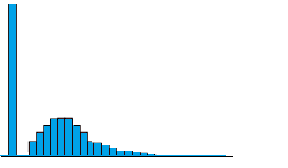

##### This is a photo of our target distribution
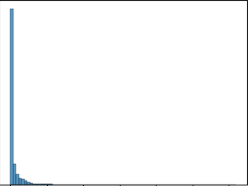

In [ ]:
#Model 1
best_params = {
    'n_iter': 2000,
    'verbose': -1,
    'objective': 'tweedie',
    'learning_rate': 0.08753282378023663,
    'colsample_bytree' : 0.92,
    'colsample_bynode' : 0.44999999999999996,
    'lambda_l1'        : 3.6277555139102864,
    'lambda_l2'        : 1.6591278779517808,
    'min_data_in_leaf': 198,
    'max_depth': 15,
    'max_bin': 835
}
from lightgbm import LGBMRegressor
lgbm= LGBMRegressor(**best_params, random_state= 73)
lgbm.fit(X, y)

[LightGBM] [Warning] lambda_l1 is set=3.6277555139102864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6277555139102864
[LightGBM] [Warning] lambda_l2 is set=1.6591278779517808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6591278779517808
[LightGBM] [Warning] min_data_in_leaf is set=198, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=198
[LightGBM] [Warning] num_iterations is set=2000, n_iter=2000 will be ignored. Current value: num_iterations=2000


In [ ]:
#Model 2
best_params = {
        'n_iter'           : 2000,
        'learning_rate': 0.03160635284169874,
        'max_depth': 11,
        'num_leaves': 455,
        'min_data_in_leaf': 63,
        'min_data_per_groups': 59,
        'verbose'          : -1,
        'objective'        : 'tweedie',
        'colsample_bytree' : 0.89,
        'colsample_bynode' : 0.44999999999999996,
        'lambda_l1'        : 3.6277555139102864,
        'lambda_l2'        : 1.6591278779517808
}

lgbm2= LGBMRegressor(**best_params, random_state= 73)
lgbm2.fit(X2, y2)

## Feature importances

In [ ]:
TOP = 150
importance_data = pd.DataFrame({'name': train.drop('target', axis= 1).columns
, 'importance': lgbm.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(25,25))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 0.01*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

In [ ]:
TOP = 150
importance_data = pd.DataFrame({'name': train.drop('target', axis= 1).columns
, 'importance': lgbm2.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(25,25))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 0.01*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

## **Test function**

In [ ]:
def preTest(data, client, hist_weather, forecast_weather, electricity, gas, locations):
    
    '''Exact same function as the train function but with some tweaks'''
    
    data= data.rename(columns={'prediction_datetime' : 'datetime'})
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
        
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)

    locations = locations.drop('Unnamed: 0', axis= 1) 
        
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude', 'longitude']].astype(float).round(1)
        
    forecast_weather= forecast_weather.merge(locations, how='left', on=['longitude','latitude'])
        
    forecast_weather.dropna(axis= 0, inplace= True)    
    
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    
    forecast_weather.drop(['origin_datetime', 'latitude', 'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    
    
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].
                                            dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                                            'datetime'], axis= 1)
                                                                     .columns)].mean().reset_index()
    forecast_weather_datetime['datetime']= pd.to_datetime(
        forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].
                              dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                              'datetime'], axis= 1)
                                                       .columns)].mean().reset_index()
    forecast_weather_datetime_county['datetime']= pd.to_datetime(
        forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

                
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)

    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    
    hist_weather.dropna(axis= 0, inplace= True)
    
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)

    hist_weather['county'] = hist_weather['county'].astype('int64')
            
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)
    
    
    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].
                                            dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                                            'datetime', 'data_block_id'], axis= 1)
                                                                     .columns)].mean().reset_index()    
    
    hist_weather_datetime['datetime']= pd.to_datetime(hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    hist_weather_datetime= hist_weather_datetime.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].
                              dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                              'datetime', 'data_block_id'], axis= 1)
                                                       .columns)].mean().reset_index() 
    hist_weather_datetime_county['datetime']= pd.to_datetime(hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    hist_weather_datetime_county= hist_weather_datetime_county.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    data['year'] = data['datetime'].dt.year
    
    data['month'] = data['datetime'].dt.month
    
    data['day'] = data['datetime'].dt.day
    
    data['hour'] = data['datetime'].dt.hour
    
    data['dayofweek']= data['datetime'].dt.dayofweek

    data['dayofyear']= data['datetime'].dt.dayofyear

        
    electricity['hour'] = electricity['datetime'].dt.hour

    
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])

    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])

    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],
                     suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    
    
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour

    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)

    
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])



    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],
                     suffixes= ('_hist_mean','_hist_mean_by_county'))

    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()

    data.drop(['level_0', 'level_1', 'row_id', 'data_block_id', 'year'], axis= 1, inplace= True)
    
    return data

In [ ]:
def create_revealed_targets_test(data, previous_revealed_targets, N_day_lags):
    '''🎯 Create new test data based on previous_revealed_targets and N_day_lags 🎯 ''' 
    for count, revealed_targets in enumerate(previous_revealed_targets) :
        day_lag = count + 2
        
        # Get hour
        revealed_targets['hour'] = pd.to_datetime(revealed_targets['datetime'], utc= True).dt.hour
        
        # Select columns and rename target
        revealed_targets = revealed_targets[['hour', 'prediction_unit_id', 'is_consumption', 'target']]
        revealed_targets = revealed_targets.rename(columns = {"target" : f"target_{day_lag}_days_ago"})
        
        
        # Add past revealed targets
        data = pd.merge(data,
                        revealed_targets,
                        how = 'left',
                        on = ['hour', 'prediction_unit_id', 'is_consumption'],
                       )
        
    # If revealed_target_columns not available, replace by nan
    all_revealed_columns = [f"target_{day_lag}_days_ago" for day_lag in range(2, N_day_lags+1)]
    missing_columns = list(set(all_revealed_columns) - set(data.columns))
    data[missing_columns] = np.nan 
    
    return data

## **Submission**

In [ ]:
previous_revealed_targets = []
env = enefit.make_env()
iter_test = env.iter_test()
for (test, revealed_targets, client_test, historical_weather_test,
     forecast_weather_test, electricity_test, gas_test,sample_prediction) in iter_test:
    
    # Rename test set to make consistent with train
    test = test.rename(columns = {'prediction_datetime': 'datetime'})
    
    # Initiate column data_block_id with default value to merge the data on
    id_column = 'data_block_id' 
    
    test[id_column] = 0
    gas_test[id_column] = 0
    electricity_test[id_column] = 0
    historical_weather_test[id_column] = 0
    forecast_weather_test[id_column] = 0
    client_test[id_column] = 0
    revealed_targets[id_column] = 0
    
    data_test = preTest(test, client_test, historical_weather_test,
                        forecast_weather_test, electricity_test, gas_test, locations)
    
    data_test['datetime']= pd.to_datetime(data_test['datetime'], utc= True).astype('int64')
    
    # Store revealed_targets
    previous_revealed_targets.insert(0, revealed_targets)
    if len(previous_revealed_targets) == N_day_lags:
        previous_revealed_targets.pop()
    
    # Add previous revealed targets
    df_test = create_revealed_targets_test(data = data_test.copy(),
                                           previous_revealed_targets = previous_revealed_targets.copy(),
                                           N_day_lags = N_day_lags
                                          )
    #Data Transformation
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_dayofyear']= (np.pi * np.sin(df_test['dayofyear']) / 183)
    df_test['cos_dayofyear']= (np.pi * np.cos(df_test['dayofyear']) / 183)
    df_test['target_mean']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].mean(1)
    df_test['target_std']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].std(1)
    df_test['target_var']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].var(1)
    for i in to_log:
        df_test[f"log_{i}"]= np.where((df_test[i])!= 0, np.log(df_test[i]),0)
    X_test = df_test.drop('currently_scored', axis= 1).values

    #Predictions
    test['target'] = lgbm.predict(X_test).clip(0)
    test['target_solar'] = lgbm2.predict(X_test).clip(0)
    test.loc[test['is_consumption']==0, "target"] = test.loc[test['is_consumption']==0, "target_solar"]  
    sample_prediction["target"] = test['target']
    
    #Sending predictions to the API
    env.predict(sample_prediction)

## If you liked it

<div style="border-radius:10px; border: #002400 solid; padding: 10px; background-color: #c8f7c8; font-size:100%;">
📝 Again guys it's so important to me to consider upvoting this notebook if you liked the work or if you forked it, And also the EDA notebook I will release in the next couple days so follow to reach out for new notebooks and also for other projects work, Thank You :)